In [1]:
import pandas as pd

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


### Crank-Nicholson
$$ \frac{u_i^{j+1} - u_i^j}{\Delta t} = \frac{D}{2 \Delta x^2}(u_{i+1}^{j+1} - 2 u_{i}^{j+1} + u_{i-1}^{j+1} + u_{i+1}^j - 2 u_i^j + u_{i-1}^j)$$
Let $r = \frac{D \Delta t}{\Delta x^2}$,
$$ -r u_{i-1}^{j+1} + (2+2r)u_i^{j+1} - r u_{j+1}^{j+1} = r u_{i+1}^j + (2-2r)u_i^j + r u_{i-1}^j$$

stable


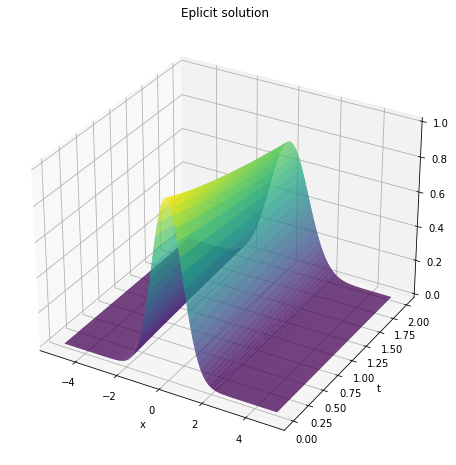

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian initial condition
def GaussianInitial(x):
    x = np.array(x)
    return np.exp(-x**2)

# Parameters
D = 0.1 # Diffusion coefficient
L = 10  # Length of the domain
T = 2.0 # Total simulation time
N = 100  # Number of spatial grid points
M = 256  # Number of time steps
dx = L / N
dt = T / M
alpha = D * dt / dx**2

# Discretize spatial and time domains
x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)

def exact_diff(t,x):
    global D
    a = 1 / np.sqrt(4*D*t +1)
    b = np.exp(-x**2/(4*D*t +1))
    u = a*b
    return u

def FTCS_diff(N, M, L, T, D, initial):
    """
    Solve the 1D diffusion equation using the FTCS scheme.

    Parameters:
    - N: Number of spatial steps (leading to N+1 grid points)
    - M: Number of time steps (leading to M+1 time intervals)
    - L: Length of the domain
    - T: Total simulation time
    - D: Diffusion coefficient
    - initial: Initial condition function

    Returns:
    - U: Solution array representing u(x,t) over the spatial and time domains
    """
    
    dx = L / N
    dt = T / M
    alpha = D * dt / dx**2

    # Discretize spatial and time domains
    x = np.linspace(-L/2, L/2, N+1)
    t = np.linspace(0, T, M+1)

    # Initialize solution array and set initial condition
    U = np.zeros((N+1, M+1))
    U[:, 0] = initial(x)

    # Time-stepping using the FTCS method
    for n in range(0, M):
        for i in range(1, N):
            U[i, n+1] = U[i, n] + alpha * (U[i+1, n] - 2*U[i, n] + U[i-1, n])
        # Apply Neumann boundary conditions (zero gradient)
        U[0, n+1] = U[1, n+1]
        U[-1, n+1] = U[-2, n+1]
        
    return U

def CFL(dx, dt, D):
    if dt <= dx**2/D:
        print('stable')
    else:
        print('unstable')
CFL(dx, dt, D)

def CK_diff(N, M, L, T, D, initial):
    dx = L / N
    dt = T / M 
    x = np.linspace(-L/2, L/2, N+1)  # Spatial grid points, N+1 in total
    u = np.zeros((N+1, M+1), dtype=np.double) # Spatial grid points x_0, ...., x_N; timesteps t_0, ...., t_M
    u[:,0] = initial(x)
    r = D * dt / dx**2
    #Ainv = np.linalg.inv(A) 
    for n in range(1, M+1):
        u[0,n] = u[-1,n-1]
        
        #b = np.zeros(N)
        #b[0] = r*(u[0, n-1] + u[0, n])
        #b[N-1] = -r*(u[N,n-1] + u[N,n])
        #v = np.dot(B, u[1:N+1,n-1])
        #u[1:N+1,n] = np.dot(Ainv,v+b)
        
        A = np.zeros((N+1, N+1))
        B = np.zeros_like(A)
        for i in range (1,N):  
            A[i,i] = 2+2*r
            A[i,i-1]= -r 
            A[i,i+1]= -r
            
            B[i,i] = 2 - 2*r
            B[i,i-1]= r
            B[i,i+1]= r

        for i in range (0,N-2):           
            A[i+1,i]=-r
            A[i,i+1]=-r
            B[i+1,i]=r
            B[i,i+1]=r
            
        A[0, 0], A[0, -1], A[0, 1] = 2 + 2*r , -r , -r 
        A[-1, -1], A[-1, -2], A[-1, 0] = 2 + 2*r , -r , -r 
        B[0, 0], B[0, -1], B[0, 1] = 2 - 2*r , r , r 
        B[-1, -1], B[-1, -2], B[-1,0] = 2 -2*r, r, r
        u_new = np.linalg.solve(A, B @ u[:,n-1])
        u[:,n] = u_new.copy()
    
    return u

u_FTCS = FTCS_diff(N, M, L, T, D, GaussianInitial)
# Create a meshgrid for plotting
t_grid, x_grid = np.meshgrid(t, x)

# Plotting the results in a 3D graph

ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u_FTCS, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Eplicit solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.savefig('diff_FTCS3d.png')

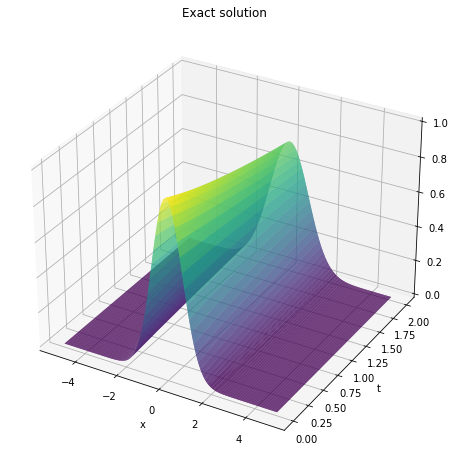

In [4]:
u_exact = exact_diff(t_grid,x_grid)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u_exact, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Exact solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.savefig('diff_exactS3d.png')

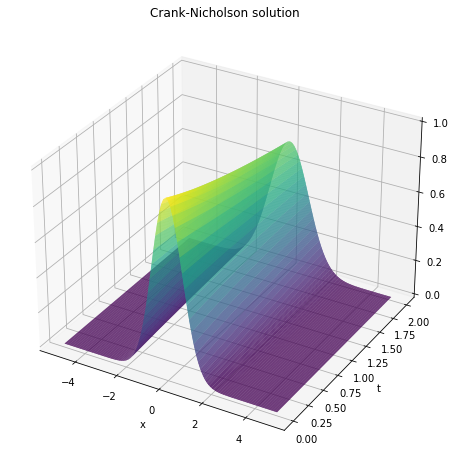

In [5]:
u_CK = CK_diff(N, M, L, T, D, GaussianInitial)
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u_CK, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_title('Crank-Nicholson solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.savefig('diff_CK3d.png')

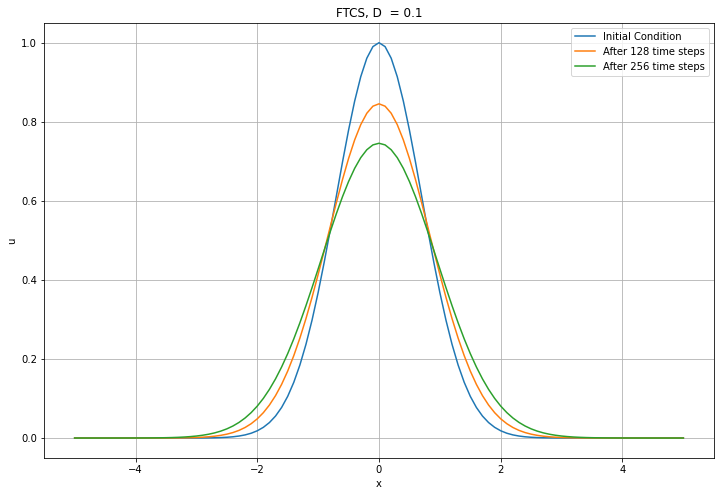

In [6]:
plt.figure()
plt.plot(x,u_FTCS[:,0], label='Initial Condition')
plt.plot(x, u_FTCS[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps')
plt.plot(x, u_FTCS[:, M], label='After ' + str(M) + ' time steps')
plt.legend()
plt.title('FTCS, D  = ' + str(D))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('diff_FTCS.png')
plt.show()


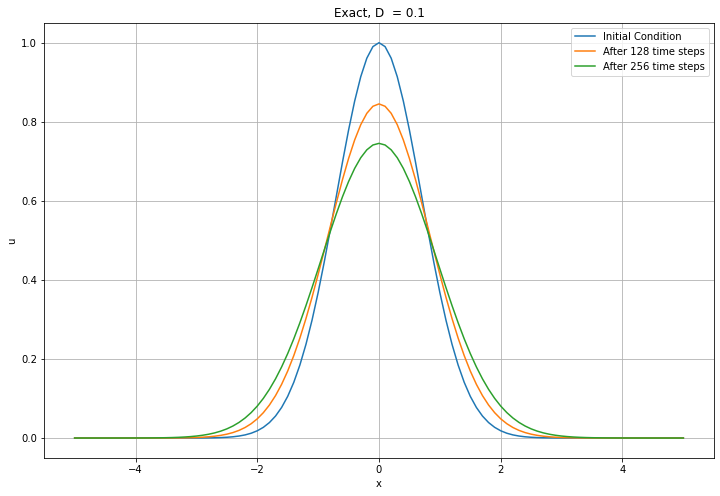

In [7]:
plt.figure()
plt.plot(x,u_exact[:,0], label='Initial Condition')
plt.plot(x, u_exact[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps')
plt.plot(x, u_exact[:, M], label='After ' + str(M) + ' time steps')
plt.legend()
plt.title('Exact, D  = ' + str(D))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('diff_exact2d.png')
plt.show()

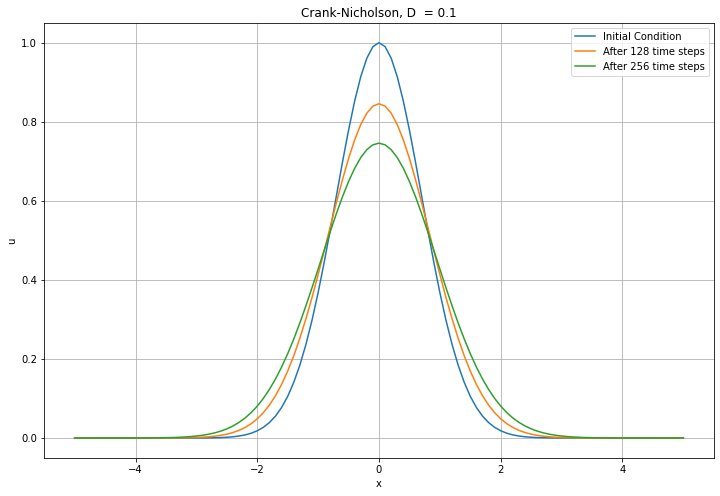

In [8]:
plt.figure()
plt.plot(x,u_CK[:,0], label='Initial Condition')
plt.plot(x, u_CK[:, int(M/2)], label='After ' + str(int(M/2))+ ' time steps')
plt.plot(x, u_CK[:, M], label='After ' + str(M) + ' time steps')
plt.legend()
plt.title('Crank-Nicholson, D  = ' + str(D))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('diff_CK2d.png')
plt.show()

In [9]:
Ut, R, rhs_des = build_linear_system(u_exact, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge, FTCS")
print_pde(w, rhs_des)

PDE derived using STRidge, FTCS
u_t = (0.100328 +0.000000i)u_{xx}
   


In [10]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [0.03278016] %


In [11]:
Ut, R, rhs_des = build_linear_system(u_FTCS, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [12]:
# Solve with STRidge
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge, FTCS")
print_pde(w, rhs_des)

PDE derived using STRidge, FTCS
u_t = (0.100153 +0.000000i)u_{xx}
   


In [13]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [0.01531819] %


In [14]:
Ut, R, rhs_des = build_linear_system(u_CK, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge, CK")
print_pde(w, rhs_des)

PDE derived using STRidge, CK
u_t = (0.100000 +0.000000i)u_{xx}
   


In [15]:
err = abs((D - w[8])*100)
print("Parameter error:", err, '%')

Parameter error: [3.23790077e-05] %


### Adding noises
Now try adding noises to the data.

In [16]:
numpy.random.seed(0)
u = u_exact
un = u + 0.001*std(u)*np.random.randn(u.shape[0],u.shape[1])
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly', space_diff = 'FD')
['1'] + rhs_des[1:]
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (0.326425 +0.000000i)u
    + (-0.948432 +0.000000i)u^2
    + (0.601019 +0.000000i)u^3
    + (0.047076 +0.000000i)u_{xx}
    + (-0.071457 +0.000000i)u^2u_{xx}
    + (0.118075 +0.000000i)u^3u_{xx}
   


In [17]:
numpy.random.seed(0)
un = U + 0.0001*std(u)*np.random.randn(u.shape[0],u.shape[1])
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly', space_diff = 'FD')
['1'] + rhs_des[1:]
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

NameError: name 'U' is not defined